In this notebook I'll show probabilistic interpretation of the nearest neighbours algorith as a mixture of Gaussians. Following Barber 2012. First I'll give an example of ... Next, I'll show how to reformulate ... using 

## Theory

This pretty much follows from [Barber, 2012]()

kNN is simple to understand and implement, and often used as a baseline.

Some limitations of this approach.
* In metric based methods, how do we measure distance? euclidean distance does not account for how data is distributed
* The whole dataset needs to be stored to make a classification since the novel point must be compared to all of the train points.
* Each distance calculation can be expensive if the datapoints are high dimensional

We can reformulate the kNN as a class conditional mixture of Gaussians. 

## Data

In [38]:
from tensorflow.contrib.keras import datasets

Keras has some nice helpers to work with the MNIST dataset

In [86]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

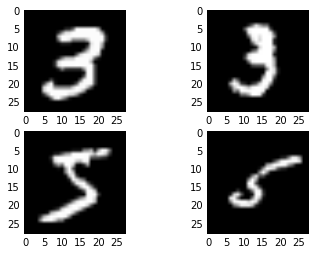

In [88]:
plt.subplot(221)
plt.imshow(X_train[y_train == 3][0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[y_train == 3][1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[y_train == 5][0], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[y_train == 5][1], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [90]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

## Metric-based nearest neighbours

In [92]:
from sklearn.neighbors import KNeighborsClassifier

train_classes = (y_train == 3) | (y_train == 5)
test_classes = (y_test == 3) | (y_test == 5)

In [104]:
knn = KNeighborsClassifier(n_neighbors=5, 
                           n_jobs=4, 
                           metric='minkowski', 
                           p=2, 
                           algorithm='ball_tree')
fitted = knn.fit(X_train[classes], y_train[classes])
y_pred = fitted.predict(X_test[test_classes])

In [109]:
from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy: {}", accuracy_score(y_pred, y_test[test_classes]))
print(confusion_matrix(y_test[test_classes], y_pred))

Accuracy: {} 0.986330178759
[[993  17]
 [  9 883]]


Not bad, but there's a few model choices we had to make. We could easilly wrap parameter selection into a GridSearchCV
for proper parameter tuning.

# Probabilistic NN

In [112]:
%pylab inline
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [113]:
class0_train = X_train[y_train == 3]
class0_test = X_test[y_test == 3]

class1_train = X_train[y_train == 5]
class1_test = X_test[y_test == 5]

In [136]:
X = X_train[classes]
y = y_train[classes]

In [133]:
sigma = 0.0001
N0 = class0_train.shape[0]
D = class0_train.shape[0]
gaussian_denom = tf.pow(2 * sigma**2 * np.pi, D/2)

p_x_given_c0 = tf.divide(1, N0 * gaussian_denom)

In [143]:
x = tf.placeholder('float', [1, N0])

In [164]:
tf.subtract(
    x,
    tf.reduce_sum(class0_train, 1, keep_dims=True))

<tf.Tensor 'Sub_4:0' shape=(6131, 6131) dtype=float32>

In [152]:
tf.reduce_sum(class0_train, 1)

<tf.Tensor 'Sum_17:0' shape=(6131,) dtype=float32>

In [169]:
np.exp((- np.array([1,2,3]) - np.array([1,1,1])) / 2*0.01 ) + np.exp((- np.array([1,2,3]) - np.array([2,2,2])) / 2*0.01 )

array([ 1.97516177,  1.96531061,  1.95550859])

In [170]:
array([ 1.97516177,  1.96531061,  1.95550859])  / array([ 1.97516177,  1.96531061,  1.95550859])

array([ 1.,  1.,  1.])

In [177]:
from scipy.stats import multivariate_normal

multivariate_normal.pdf([1,2, 3,4], mean=[0, 1, 1, 1], cov=2)

0.0001489278654206577

In [176]:
?multivariate_normal

# Bayesian NN

Stick a prior on $P(c=0)$ and $P(c=1)$ inference with MCMC.

In [163]:
np.exp(np.array([1,2,3]) - np.array([1,1,1])) + np.exp(np.array([1,2,3]) - np.array([1,1,1]))

array([  2.        ,   5.43656366,  14.7781122 ])